<a href="https://colab.research.google.com/github/luoterolb/MIT-mod4/blob/main/4_1_CM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso de Estudio 4.1 Sistema de recomendación

#### Nota: Si en algún momento cierra este notebook tendrá que volver a ejecutar todas las celdas de nuevo al abrirlo.

#### Nota: Puede que obtenga diferentes resultados numéricos al ejecutar el notebook en diferentes ocasiones. Esto es normal, simplemente entregue los resultados obtenidos.

## PYTHON PRINCIPIANTE

Como esta es la versión para principiantes, se ha incluído la mayor parte del código para ayudarle con el caso.

**Primero, rellene su información de contacto en la celda siguiente. A continuación, únicamente tendrá que escribir las respuestas a las preguntas que se plantean. Para el resto de celdas, simplemente ejecútelas seleccionando el botón de Run, en la parte superior del notebook**


Información de contacto

Nombre: Lucía Otero

mail: luoterolb@gmail.com

Teléfono: +59899599517

## Configuración

Ejecute (Run) estas celdas para instalar los paquetes necesarios para completar el caso de estudio. Esto podría llevar unos minutos así que sea paciente.

In [ ]:
!pip install --upgrade pip
!pip install surprise==0.1
print('Librerías instaladas con éxito!')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 8.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 42.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633961 sha256=b6ed7861d8a13bda4a95bff157996353b650456d6c8607ccf21fe6baa9f8ad0b
  Stored in directory: /root/.cache/pip/wheels/45/cc/aa/02a53fc2982d55288bb9d37a397fdbf8552f193a10ba357074
Successfully built scikit-surprise
Librerías instaladas con éxito!


Si no ha obtenido ningún texto en rojo indicando error entonces la instalación ha terminado con éxito. El texto en amarillo son avisos, no errores.

<h1>Atención:</h1>

Ahora ha de reiniciar el entorno de ejecución. Para ello vaya a:

> Entorno de ejecución > _Reiniciar entorno de ejecución_

en la parte superior de su pantalla. Esto asegurará que sus cambio se han realizado con éxito.

## Importar

Importe las librerías necesarias para el desarrollo del caso.

In [ ]:
import pandas as pd
import matplotlib
from surprise import Dataset, SVD, NormalPredictor, BaselineOnly, KNNBasic, NMF
from surprise.model_selection import cross_validate, KFold
%matplotlib inline
print('Librerías importadas con éxito!')

Librerías importadas con éxito!


## Datos

In [ ]:
data = Dataset.load_builtin('ml-100k')
print('\n\nData load successful!')

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


Data load successful!


[texto del vínculo](https://)

Carga de histograma con las valoraciones de 1 a 5 según cantidad de usuarios que puntuaron las peliculas



Histograma generado con éxito!


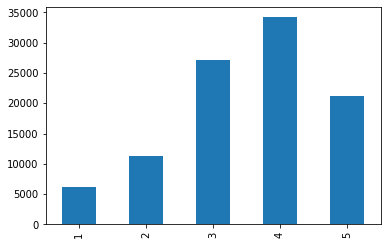

In [ ]:
# 1. Obtener el archivo de valoraciones (ratings) del objeto "data"
ratings_file = data.ratings_file

# 2. Cargue la tabla usando pandas, una herramienta común de tratamiento de datos
# Se establecen los nombres de las columnas de forma manual en este caso
col_names = ['user_id', 'item_id', 'rating', 'timestamp']
raw_data = pd.read_table(ratings_file, names=col_names)

# 3. Obtener la columna de valoraciones (ratings)
ratings = raw_data.rating

# 4. Generar un gráfico de barras/histograma con dichos datos
ratings.value_counts().sort_index().plot.bar()

print('\n\nHistograma generado con éxito!')

In [ ]:
print(raw_data)

       user_id  item_id  rating  timestamp
0          196      242       3  881250949
1          186      302       3  891717742
2           22      377       1  878887116
3          244       51       2  880606923
4          166      346       1  886397596
...        ...      ...     ...        ...
99995      880      476       3  880175444
99996      716      204       5  879795543
99997      276     1090       1  874795795
99998       13      225       2  882399156
99999       12      203       3  879959583

[100000 rows x 4 columns]


In [ ]:
len(ratings)

100000

In [ ]:
raw_data.nunique()

user_id        943
item_id       1682
rating           5
timestamp    49282
dtype: int64

In [ ]:
raw_data.shape

(100000, 4)

In [ ]:
print(raw_data.describe(include = 'all' ))

            user_id        item_id         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e+08
50%       447.00000     322.000000       4.000000  8.828269e+08
75%       682.00000     631.000000       4.000000  8.882600e+08
max       943.00000    1682.000000       5.000000  8.932866e+08


<h1>PREGUNTA 1: ANÁLISIS DE DATOS</h1>

Describe la forma de los datos, como estan distribuidos..Cuantas valoraciones hay disponibles?.


Respuesta:
Hay 100000 entradas de valoraciones, que van del 1 al 5 como números enteros.
A partir del histograma, se evidencia un sesgo a la derecha (mayor cantidad de valoraciones entre 3 y 5 que entre 1 y 2)


## Modelo 1: aleatorio

In [ ]:
# Crear el objeto para el modelo
model_random = NormalPredictor()
print('\n\nModelo creado con éxito!')



Modelo creado con éxito!


In [ ]:
# Entrenar con los datos usando validación cruzada con k=5
# iteraciones, midiendo el RECM
model_random_results = cross_validate(model_random, data, measures=['RMSE'], cv=5, verbose=True)
print('\n\nEntrenamiento del modelo finalizado con éxito!')

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5261  1.5211  1.5186  1.5245  1.5218  1.5224  0.0026  
Fit time          0.12    0.13    0.16    0.16    0.16    0.15    0.02    
Test time         0.23    0.25    0.22    0.23    0.14    0.21    0.04    


Entrenamiento del modelo finalizado con éxito!


## Modelo 2: filtrado colaborativo basado en usuarios

In [ ]:
# Crear el objeto para el modelo
model_user = KNNBasic(sim_options={'user_based': True})
print('\n\nModelo creado con éxito!')



Modelo creado con éxito!


In [ ]:
# Entrenar con los datos usando validación cruzada con k=5
# iteraciones, midiendo el RECM
# Atención, esto podría generar un output con muchas líneas impresas
# Puede usar "verbose = False" para prevenir esto
model_user_results = cross_validate(model_user, data, measures=['RMSE'], cv=5, verbose=True)
print('\n\nEntrenamiento del modelo finalizado con éxito!')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9804  0.9781  0.9823  0.9700  0.9798  0.9781  0.0043  
Fit time          0.38    0.43    0.47    0.43    0.41    0.42    0.03    
Test time         3.37    3.34    3.40    3.31    3.40    3.37    0.04    


Entrenamiento del modelo finalizado con éxito!


## Modelo 3: filtrado colaborativo basado en ítems

In [ ]:
# Crear el objeto para el modelo
model_item = KNNBasic(sim_options={'user_based': False})
print('\n\nModelo creado con éxito!')



Modelo creado con éxito!


In [ ]:
# Entrenar con los datos usando validación cruzada con k=5
# iteraciones, midiendo el RECM
# Atención, esto podría generar un output con muchas líneas impresas
# Puede usar "verbose = False" para prevenir esto
model_item_results = cross_validate(model_item, data, measures=['RMSE'], cv=5, verbose=True)
print('\n\nEntrenamiento del modelo finalizado con éxito!')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9702  0.9715  0.9757  0.9717  0.9812  0.9740  0.0040  
Fit time          0.59    0.60    0.59    0.59    0.59    0.59    0.00    
Test time         3.95    3.79    3.96    3.85    3.86    3.88    0.07    


Entrenamiento del modelo finalizado con éxito!


<h1>PREGUNTA 2: MODELOS DE FILTRADO COLABORATIVO</h1>

**Compare los resultados de los modelos de filtrado colaborativo basados en usuarios e ítems. ¿Qué diferencias encuentra entre ambos? ¿Qué diferencias encuentra entre dichos modelos y el modelo aleatorio? ¿Puede explicar qué podría haber motivado dichas diferencias en los resultados?**

Respuesta:
Los resultados de los modelos de filtrado colaborativo basados en usuarios e ítems presentan un mejor desempeño respecto al modelo aleatorio (RMSE 0.98/0.97 filtrados colaborativos vs 1.5 aleatorio). Sin embargo, presentan un tiempo de cómputo mucho mayor que el modelo aleatorio. Estos resultados son esperabales, ya que los filtrados colaborativos son algoritmos más refinados que tienen en cuenta las valoraciones personalizadas del dataset.
Si bien los resultados de los filtrados colaborativos son similares, se observa que el basado en ítems presenta un fit time mayor que el basado en usuarios (test time similares). Esto se debe a que el dataset incluye 100000 valoraciones de 17000 películas, esto hace que el número de valoraciones sea mayor al número de ítems, por lo que el tiempo de ajuste del modelo basado en ítems sea mayor porque tiene que procesar mayor número de datos.

## Modelo 4: factorización de matriz

In [ ]:
# Crear el objeto para el modelo
model_matrix = SVD()
print('\n\nModelo creado con éxito!')



Modelo creado con éxito!


In [ ]:
# Entrenar con los datos usando validación cruzada con k=5
# iteraciones, midiendo el RECM
# Atención, esto podría llevar cierto tiempo (2-3 minutos), sea paciente
model_matrix_results = cross_validate(model_matrix, data, measures=['RMSE'], cv=5, verbose=True)
print('\n\nEntrenamiento del modelo finalizado con éxito!')

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9379  0.9368  0.9411  0.9377  0.9270  0.9361  0.0048  
Fit time          4.94    4.91    4.91    4.94    4.96    4.93    0.02    
Test time         0.16    0.26    0.20    0.25    0.15    0.21    0.05    


Entrenamiento del modelo finalizado con éxito!


<h1>PREGUNTA 3: MODELO DE FACTORIZACIÓN DE MATRIZ</h1>

**El modelo de factorización de matriz es diferente de los modelos de filtrado colaborativo. Describa brevemente en qué consisten dichas diferencias. También, compare de nuevo el RECM respecto al resto de modelos. ¿Mejora? ¿Puede ofrecer alguna explicación de por qué mejora/empeora?**

Respuesta:
RMSE bajó a 0.93, lo que es una mejora en el desempeño. El fit time es mayor, sin embargo el test time es mejor. El motivo es que se subdividen la matriz usuario ítems en dos submatrices, agilizando el tiempo de cómputo.
Sin embargo, no se puede sacar una conclusión general basándose únicamente en una de las métricas.


## Precisión and exhaustividad @`k` (*precision and recall @k*)

Queremos calcular la precisión y la exhaustividad para 2 valores de `k`: 5 y 10. Hemos incluído unas cuantas líneas de código que le ayudarán a conseguirlo.

Primero, definimos una función que toma algunas predicciones, un valor de `k` y un parámetro de umbral. Este código ha sido adaptado de la siguiente [fuente](http://surprise.readthedocs.io/en/stable/FAQ.html?highlight=precision#how-to-compute-precision-k-and-recall-k).

**Asegúrese de que ejecuta esta celda**

In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Devuelve la precision y la exhaustividad @k para cada usuario'''

    # Primero asocie las predicciones a cada usuario
    user_est_true = dict()
    for uid, _, true_r, est, _ in predictions:
        current = user_est_true.get(uid, list())
        current.append((est, true_r))
        user_est_true[uid] = current

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Ordene las valoraciones de los usuarios por su valor estimado
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Número de ítems relevantes
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Número de ítems recomendados en el top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Número de ítems relevantes y recomendados en el top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@k: proporción de ítems recomendados que son relevantes
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Exhaustividad@K: proporción de ítems relevantes que se recomiendan
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

print('\n\nFunción creada con éxito!')



Función creada con éxito!


A continuación, calculamos la precisión y exhaustividad @`k` = 5 y 10. Usamos validación cruzada con 5 iteraciones de nuevo para promediar los resultados a lo largo de toda la base de datos.

Sea paciente porque esto podría llevar cierto tiempo en ejecutarse.

<h1>PREGUNTA 4: PRECISIÓN/EXHAUSTIVIDAD</h1>

In [ ]:
# Cree una lista de los valores de k
K = [5,10]

# Cree una lista de modelos
models = [model_random, model_user, model_item, model_matrix]
model_names = ['modelo aleatorio', 'filtrado colaborativo usuario',
               'filtrado colaborativo ítem','factorización de matriz']

# Cree un objeto de validación cruzada con k-iteraciones (diferente "k")
kf = KFold(n_splits=5)

for k in K:
    for i, model in enumerate(models):
        print(f'>>> k={k}, modelo={model_names[i]}')
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # La precisión y la exhaustividad pueden promediarse sobre todos los usuarios
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))

        print('>>> precisión:', round(sum(p) / len(p), 3))
        print('>>> exhaustividad  :', round(sum(r) / len(r), 3))
        print('\n')

print('\n\nCálculo de la precisión y la exhaustividad finalizado con éxito!')

>>> k=5, modelo=modelo aleatorio
>>> precisión: 0.589
>>> exhaustividad  : 0.338


>>> k=5, modelo=filtrado colaborativo usuario
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
>>> precisión: 0.762
>>> exhaustividad  : 0.452


>>> k=5, modelo=filtrado colaborativo ítem
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
>>> precisión: 0.82
>>> exhaustividad  : 0.389



**Calcule la precisión y la exhaustividad, para cada uno de los 4 modelos, con `k` = 5 y 10. Es decir, 2 x 2 x 4 = 16 valores numéricos. ¿Nota algo diferente en estos valores? ¿Algo diferente de los valores de RECM calculados anteriormente?**

Respuesta:
Valores Calculados para k= 5 y k= 10 en los 4 modelos:

k=5, modelo=modelo aleatorio precisión: 0.589 exhaustividad : 0.338

k=5, modelo=filtrado colaborativo usuario precisión: 0.762 exhaustividad : 0.452

k=5, modelo=filtrado colaborativo ítem precisión: 0.82 exhaustividad : 0.389

k=5, modelo=factorización de matriz precisión: 0.784 exhaustividad : 0.432

k=10, modelo=modelo aleatorio precisión: 0.587 exhaustividad : 0.431

k=10, modelo=filtrado colaborativo usuario precisión: 0.735 exhaustividad : 0.592

k=10, modelo=filtrado colaborativo ítem precisión: 0.789 exhaustividad : 0.535

k=10, modelo=factorización de matriz precisión: 0.755 exhaustividad : 0.565

Con el aumento de k se ve una mejora en la exhaustividad de los cuatro modelos, pero no de la precisión, aunque se esperan métricas más veraces. Teniendo en cuenta que el aumento de k conlleva un aumento en el tiempo de cálculo, debe considerase si esta mejora lo amerita.
Se observa que ningún método logra destacarse completamente, ya que el que presenta ayor precisión (colaborativo basado en ítems) no es el que presenta mayor exhaustividad (colaborativo basado en usuarios, para k=10), ni menor RECM (factorización de matrices). Al momento de elegir el método, se deberán tener en cuenta todos estos parámetros.

##  Top-`n` Predicciones

Finalmente, queremos ver cómo son las recomendaciones y las estimaciones de valoraciones de los usuarios.

In [ ]:
def get_top_n(predictions, n=5):
    '''Devuelve las top-N recomendaciones para cada usuario de un conjunto de predicciones.

    Argumentos:
        predictions(lista de objetos de predicción): lista de la predicciones,
            tal y como se obtienen del método "test" de un algoritmo
        n(int): número de recomendaciones a mostrar para cada usuario.
            Por defecto es 10.

    Salidas:
    Un diccionario donde las keys son las IDs de los usuarios y los valores son
    una lista de tuples:
        [(item id, estimación de la valoración), ...] de tamaño n.
    '''

    # Primero asocie las predicciones a cada usuario.
    top_n = dict()
    for uid, iid, true_r, est, _ in predictions:
        current = top_n.get(uid, [])
        current.append((iid, est))
        top_n[uid] = current

    # A continuación ordene las predicciones para cada usuario y obtenga las
    # n predicciones más elevadas
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

print('Función creada con éxito!')

Función creada con éxito!


Por último, ejecutamos esta función en cada uno de los modelos, primero entrenando en **la totalidad** de los datos disponibles, y después prediciendo los datos que faltan. Usamos `n` = 5, pero puede elegir cualquier valor razonable de n.

Esto podría llevar cierto tiempo de computación, así que sea paciente.


In [ ]:
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()
print('\n\nConjuntos de prueba y entrenamiento creados con éxito!')



Conjuntos de prueba y entrenamiento creados con éxito!


In [ ]:
for model in models:
    model.fit(trainset)
    predictions = model.test(testset)
    top_n = get_top_n(predictions, n=5)
    # Muestre el primer usuario de la base de datos
    user = list(top_n.keys())[0]
    print(f'model: {model}, {user}: {top_n[user]}')

print('\n\nCálculo de las top-N predicciones realizado con éxito!')

model: <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7ffacb4bdd90>, 196: [('346', 5), ('234', 5), ('796', 5), ('32', 5), ('16', 5)]
Computing the msd similarity matrix...
Done computing similarity matrix.
model: <surprise.prediction_algorithms.knns.KNNBasic object at 0x7ffacb00ed50>, 196: [('1189', 5), ('1500', 5), ('814', 5), ('1536', 5), ('1599', 5)]
Computing the msd similarity matrix...
Done computing similarity matrix.
model: <surprise.prediction_algorithms.knns.KNNBasic object at 0x7ffacb5bce90>, 196: [('1414', 4.666666666666667), ('1309', 4.5), ('1310', 4.5), ('1675', 4.333333333333333), ('1676', 4.3076923076923075)]
model: <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7ffacb48fa10>, 196: [('480', 4.650393788247126), ('408', 4.6222372108993675), ('474', 4.592778542258826), ('169', 4.576215140516381), ('357', 4.552465261151282)]


Cálculo de las top-N predicciones realizado con éxito!


<h1>PREGUNTA 5: TOP-N PREDICCIONES</h1>

**¿Tienen sentido las top-n predicciones que ha obtenido? ¿Cuál es el valor de las valoraciones (1-5) de estas predicciones? ¿Cómo podría usar estas predicciones en la vida real si estuviera intentando construir un sistema de recomendación genérico para una compañía?**

Respuesta:

Modelo aleatorio: 196: [('346', 5), ('234', 5), ('796', 5), ('32', 5), ('16', 5)]

Basado en usuarios: 196: [('1189', 5), ('1500', 5), ('814', 5), ('1536', 5), ('1599', 5)]

Basado en ítems: 196: [('1414', 4.666666666666667), ('1309', 4.5), ('1310', 4.5), ('1675', 4.333333333333333), ('1676', 4.3076923076923075)]

Factorización de matriz:196: [('480', 4.650393788247126), ('408', 4.6222372108993675), ('474', 4.592778542258826), ('169', 4.576215140516381), ('357', 4.552465261151282)]

Asmuiendo que las películas se encuentran ordenadas por número según género, se ve que el modelo aleatorio presenta números bastantes dispares. Con alguna excepción, los demás métodos parecen sugerir dentro de rangos más acotados.

Resultados Valoraciones para los usuarios:

Las predicciones obtenidas tienen sentido debido para todos los grupos los valores son mayores a  4,30 y 4,67.


 [('302', 5), ('465', 5), ('387', 5), ('486', 5), ('193', 5)]
 [('1189', 5), ('1500', 5), ('814', 5), ('1536', 5), ('1599', 5)]
 [('1414', 4.666666666666667), ('1309', 4.5), ('1310', 4.5), ('1675', 4.333333333333333), ('1676', 4.3076923076923075)]
 [('318', 4.658668397510697), ('357', 4.501237825621047), ('423', 4.4731957057706655), ('483', 4.455667080471217), ('64', 4.428957850749056)

<hr>

[texto del enlace](https://)¡Buen trabajo! Asegúrese de que comprueba la sección **Entrega** del manual de instrucciones para terminar y entregar este caso correctamente.

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
0.9888399285704299
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
0.981324495332604
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
0.9780161178165934
Computing the msd similarity matrix...
Done computing similarity mat

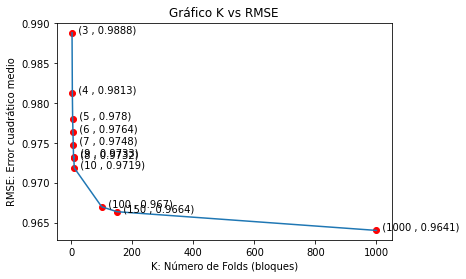

In [ ]:
# Evaluar RMSE para los siguientes valores de K
# se busca determinar el K óptimo de manera gráfica.
# --------------------------------------------------
k_value = [3,4,5,6,7,8,9,10,100,150,1000]
error = list()
for i  in k_value:
  model_user_results = cross_validate(model_user, data, measures=['RMSE'],cv=i, verbose=False)
  error_medio=(model_user_results['test_rmse'].sum())/i
  error.append(error_medio)
  print(error_medio)
# Pasando los resultados a un DataFrame
# -------------------------------------
dicc ={'k_value(K)':k_value, 'error(RMSE)':error}
df=pd.DataFrame(dicc)


import matplotlib.pyplot as plt
import math
plt.plot(k_value,error)
plt.scatter(k_value, error,marker='o', color='r')
annotations=[]
for i in range(0,len(error)):
  annotations.append('  ('+ str(k_value[i]) + ' , ' + str(round(error[i],4)) +')')
for i, label in enumerate(annotations):
    plt.text(k_value[i], error[i],label)
plt.xlabel('K: Número de Folds (bloques)')
plt.ylabel('RMSE: Error cuadrático medio')
plt.title('Gráfico K vs RMSE')
plt.show()

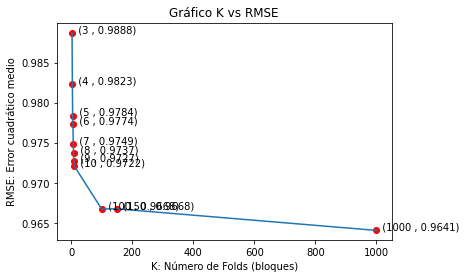

In [ ]:
dicc ={'k_value(K)':k_value, 'error(RMSE)':error}
df=pd.DataFrame(dicc)


import matplotlib.pyplot as plt
import math
plt.plot(k_value,error)
plt.scatter(k_value, error,marker='o', color='r')
annotations=[]
for i in range(0,len(error)):
  annotations.append('  ('+ str(k_value[i]) + ' , ' + str(round(error[i],4)) +')')
for i, label in enumerate(annotations):
    plt.text(k_value[i], error[i],label)
plt.xlabel('K: Número de Folds (bloques)')
plt.ylabel('RMSE: Error cuadrático medio')
plt.title('Gráfico K vs RMSE')
plt.show()